In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras
from keras import layers

In [44]:
# Path to the dataset
DATA_DIR = 'data/train/'

In [46]:
# Load the dataset
images = []
labels = []

# Loop through each folder in the dataset
for folder in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder)
    if os.path.isdir(folder_path):
        # Extract the character label from the folder name (e.g., Sample001 -> '001')
        label = folder[6:]  # Assuming 'SampleXXX' format

        # Loop through each image in the folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            # Read the image in grayscale
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28, 28))

            # Append image and label to the lists
            images.append(img)
            labels.append(label)
            
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Reshape the images to add a channel dimension (for grayscale images)
images = images.reshape(-1, 28, 28, 1)

# Normalize pixel values to the range [0, 1]
images = images / 255.0

In [47]:
# Display the first 10 images and labels
print(images[0])

[[[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1. 

In [48]:
# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [49]:
# Split the dataset into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

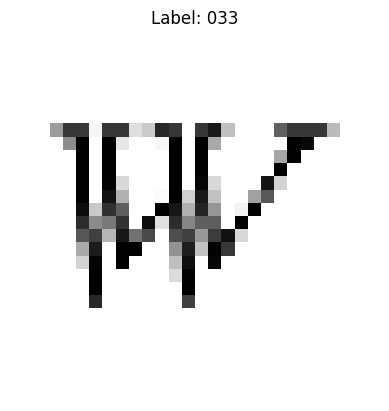

In [50]:
# Select an image to visualize (e.g., the first image in the dataset)
image_index = 0

# Extract the corresponding image from the dataset (use squeeze() to remove the extra channel dimension)
image_to_show = X_train[image_index].squeeze()

# Display the image
plt.imshow(image_to_show, cmap='gray')
plt.title(f"Label: {label_encoder.inverse_transform([y_train[image_index]])[0]}")
plt.axis('off')  # Turn off axis
plt.show()


In [51]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [52]:
# Define the model
model = keras.Sequential([
    # First Convolutional Layer
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output to feed into Dense layers
    layers.Flatten(),

    # Fully Connected Layer with Dropout
    layers.Dense(128, activation='relu', input_dim=57600),
    layers.Dropout(0.5),

    # Output Layer with Softmax activation for multi-class classification
    layers.Dense(62, activation='softmax', input_dim=57600)
])

# Display the model architecture
model.summary()

X:\character-classification\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
X:\character-classification\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,742 (905.24 KB)

 Trainable params: 231,742 (905.24 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
print(X_train.shape)  # Should be (num_samples, 28, 28, 1)
print(X_val.shape)    # Should be (num_samples, 28, 28, 1)

(42537, 28, 28, 1)
(10635, 28, 28, 1)


In [55]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=10)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


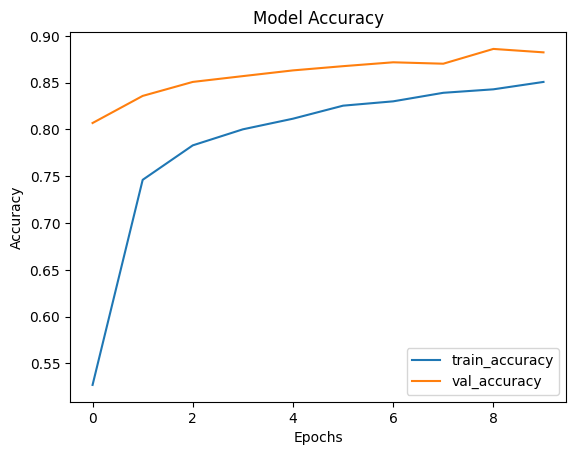

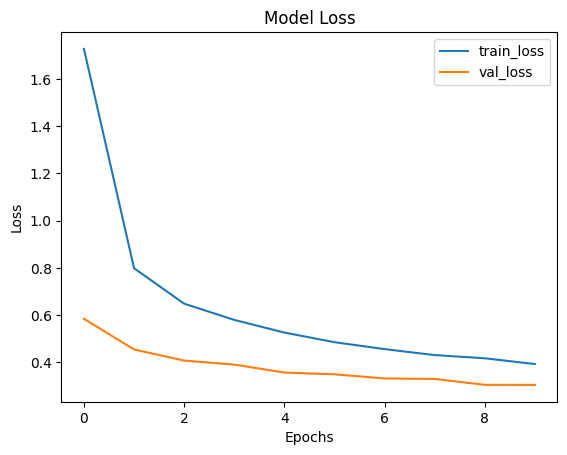

In [56]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [57]:
history.history['accuracy']

[0.5270000100135803,
 0.7461504340171814,
 0.7829889059066772,
 0.8001269698143005,
 0.811481773853302,
 0.8253990411758423,
 0.8300303220748901,
 0.8391517996788025,
 0.8428661823272705,
 0.8507652282714844]